# TueSNLP - Assignment 2

## Linear regression
The assignment and data are available here: https://snlp2018.github.io/assignments.html.

The data (already splitted in training and testing sets) is a list of timestamps of tweets, in the UNIX format. The goal of the assignment is to model the distribution of tweets during the hours of a day.

### Exercise 1
Load the data, convert it into more informative format and count the number of tweets in each hour of each day. The goal of the exercise is to output two `numpy` arrays, one with the hours (0,1,...,23,0,1,...) and the other with the count of tweets in each hour.

In [1]:
# libraries
import gzip
import numpy as np
import pandas as pd
import time

In [2]:
# read data ("rt" mode makes sure we read as text)
with gzip.open("data/timestamps.train.gz", "rt") as input_f:
    timestamps_train_raw = input_f.read().splitlines()

It looks like this:

In [3]:
print(timestamps_train_raw[0:10])

['1522533600', '1522533600', '1522533602', '1522533603', '1522533603', '1522533604', '1522533604', '1522533604', '1522533605', '1522533606']


We can convert the UNIX format with `time.localtime()`; for example:

In [4]:
print(time.localtime(int(timestamps_train_raw[0])))
print(time.localtime(int(timestamps_train_raw[1])))
print(time.localtime(int(timestamps_train_raw[2])))

time.struct_time(tm_year=2018, tm_mon=4, tm_mday=1, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=6, tm_yday=91, tm_isdst=1)
time.struct_time(tm_year=2018, tm_mon=4, tm_mday=1, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=6, tm_yday=91, tm_isdst=1)
time.struct_time(tm_year=2018, tm_mon=4, tm_mday=1, tm_hour=0, tm_min=0, tm_sec=2, tm_wday=6, tm_yday=91, tm_isdst=1)


We can see that the attribute `hour` might just be what we need:

In [5]:
timestamps_train_int = [int(entry) for entry in timestamps_train_raw] # convert to integer
timestamps_train_int[0:10]

[1522533600,
 1522533600,
 1522533602,
 1522533603,
 1522533603,
 1522533604,
 1522533604,
 1522533604,
 1522533605,
 1522533606]

In [6]:
# convert with localtime and extract hour attribute
timestamps_train_converted = [time.localtime(entry) for entry in timestamps_train_int]
timestamps_train_hours = np.array([entry.tm_hour for entry in timestamps_train_converted])
timestamps_train_hours[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

We want to count tweets in each hour in each day, so we need more information, i.e. year, month, day as well:

In [7]:
timestamps_train_keys = [(entry.tm_year, entry.tm_mon, entry.tm_mday, entry.tm_hour) 
                         for entry in timestamps_train_converted]

In [8]:
timestamps_train_keys[0:5]

[(2018, 4, 1, 0),
 (2018, 4, 1, 0),
 (2018, 4, 1, 0),
 (2018, 4, 1, 0),
 (2018, 4, 1, 0)]

In [9]:
train_df = pd.DataFrame()
train_df["key"] = timestamps_train_keys
train_df.head()

,key
0,"(2018, 4, 1, 0)"
1,"(2018, 4, 1, 0)"
2,"(2018, 4, 1, 0)"
3,"(2018, 4, 1, 0)"
4,"(2018, 4, 1, 0)"


In [10]:
counts_df = train_df.groupby(["key"]).size().reset_index(name="count")
counts_df["hour"] = [entry[3] for entry in counts_df["key"]]
counts_df.head(10)

,key,count,hour
0,"(2018, 4, 1, 0)",5682,0
1,"(2018, 4, 1, 1)",3480,1
2,"(2018, 4, 1, 2)",1782,2
3,"(2018, 4, 1, 3)",1029,3
4,"(2018, 4, 1, 4)",911,4
5,"(2018, 4, 1, 5)",836,5
6,"(2018, 4, 1, 6)",1112,6
7,"(2018, 4, 1, 7)",2783,7
8,"(2018, 4, 1, 8)",2820,8
9,"(2018, 4, 1, 9)",3588,9


### Exercise 2
Fit a linear model to predict the number of tweets in each hour of the day, using `sklearn.linear_model`. Output `R^2` score on training and testing data, and make predictions for a few samples.

In [11]:
import sklearn.linear_model as lm

In [12]:
# initialize model
lm_model = lm.LinearRegression()

# train
lm_model.fit(X = counts_df["hour"].values.reshape(-1,1), 
             y = counts_df["count"]) # reshape needed to obtain 2D array)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [13]:
# R^2 score on training data
lm_model.score(X = counts_df["hour"].values.reshape(-1,1), 
             y = counts_df["count"]) # reshape needed to obtain 2D array)

0.5180059433647819

In [14]:
# coefficients
print(lm_model.coef_)
print(lm_model.intercept_)

[641.0975942]
79.61377777777761


In [15]:
# some predictions
X_predict = np.array([0, 8, 12, 18, 23]).reshape(-1,1)
lm_model.predict(X_predict)

array([   79.61377778,  5208.3945314 ,  7772.78490821, 11619.37047343,
       14824.85844444])

Do all this with test data as well :)

In [16]:
# read and process data
with gzip.open("data/timestamps.test.gz", "rt") as input_f:
    timestamps_test_raw = input_f.read().splitlines()

timestamps_test_converted = [time.localtime(int(entry)) for entry in timestamps_test_raw]
timestamps_test_hours = np.array([entry.tm_hour for entry in timestamps_test_converted])
timestamps_test_keys = [(entry.tm_year, entry.tm_mon, entry.tm_mday, entry.tm_hour) 
                         for entry in timestamps_test_converted]

In [17]:
# df
test_df = pd.DataFrame()
test_df["key"] = timestamps_test_keys
test_df.head()
test_counts_df = test_df.groupby(["key"]).size().reset_index(name="count")
test_counts_df["hour"] = [entry[3] for entry in test_counts_df["key"]]

In [18]:
# model
lm_model.score(X = test_counts_df["hour"].values.reshape(-1,1),
               y = test_counts_df["count"]) # reshape needed to obtain 2D array

0.053960363488884555

Pretty low.

### Exercise 3
Fit 9 polynomial regression models, each increasing by one the order of the function, i.e. exponent of the maximal term, starting from 2. Output `R^2` score for each model on training and testing data.

We use `PolynomialFeatures`:

In [19]:
from sklearn.preprocessing import PolynomialFeatures

In [20]:
# polynomial features
poly = PolynomialFeatures(degree = 2) # initialize constructor
poly_counts = poly.fit_transform(counts_df["count"].values.reshape(-1,1)) # add polynomial feature

In [21]:
# model
lm_model = lm.LinearRegression()
lm_model.fit(X = counts_df["hour"].values.reshape(-1,1), y = poly_counts)
lm_model.score(X = counts_df["hour"].values.reshape(-1,1), y = poly_counts)

/home/mic_he/lib/python3.5/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.2866714225119515

As a function:

In [22]:
def polynomial_regression(n, X_train, y_train, X_test, y_test):
    poly = PolynomialFeatures(degree = n) # initialize constructor
    poly_X_train = poly.fit_transform(X_train) # add polynomial feature
    lm_model = lm.LinearRegression()
    lm_model.fit(X = poly_X_train, y = y_train)
    score_train = lm_model.score(X = poly_X_train, y = y_train)
    print("R^2 score with degree "+str(n)+" on training data: "+str(score_train))
    poly_X_test = poly.fit_transform(X_test)
    score_test = lm_model.score(X = poly_X_test, y = y_test)
    print("R^2 score with degree "+str(n)+" on testing data: "+str(score_test))   

For example:

In [23]:
polynomial_regression(n = 2, X_train = counts_df["hour"].values.reshape(-1,1), 
                      y_train = counts_df["count"].values.reshape(-1,1), 
                      X_test = test_counts_df["hour"].values.reshape(-1,1),
                      y_test = test_counts_df["count"].values.reshape(-1,1))

R^2 score with degree 2 on training data: 0.5212131379797482
R^2 score with degree 2 on testing data: 0.060189867017389154


Let's run it for each value from 2 to 9 on both training and testing data:

In [24]:
X_train = counts_df["hour"].values.reshape(-1,1)
y_train = counts_df["count"].values.reshape(-1,1)
X_test = test_counts_df["hour"].values.reshape(-1,1)
y_test = test_counts_df["count"].values.reshape(-1,1)

for n in range(2,10):
    polynomial_regression(n, X_train, y_train, X_test, y_test)
    print("")

R^2 score with degree 2 on training data: 0.5212131379797482
R^2 score with degree 2 on testing data: 0.060189867017389154

R^2 score with degree 3 on training data: 0.6156576360819128
R^2 score with degree 3 on testing data: 0.09684404167136207

R^2 score with degree 4 on training data: 0.6300433428418803
R^2 score with degree 4 on testing data: 0.0399555868664474

R^2 score with degree 5 on training data: 0.6827144707505652
R^2 score with degree 5 on testing data: 0.08407760569658584

R^2 score with degree 6 on training data: 0.6860602020493982
R^2 score with degree 6 on testing data: 0.08237905960931335

R^2 score with degree 7 on training data: 0.6932243442370838
R^2 score with degree 7 on testing data: 0.09112296550693255

R^2 score with degree 8 on training data: 0.7014440741951585
R^2 score with degree 8 on testing data: 0.09284888814166503

R^2 score with degree 9 on training data: 0.7033983505131709
R^2 score with degree 9 on testing data: 0.09416684850350865



Performance on training set peak at degree 9. However performance on testing set always very poor.

### Exercise 4
Try to use the predictor `hour` not as continuous variable but as categorial, i.e. encode it with one-hot encoding

In [25]:
# one-hot encoding function
def onehot_encoder(input_array):
    unique_elements = list(set(input_array)) # the "vocabulary" of the input
    output_array = [None]*len(input_array) # output has the same length as input
    for i in range(0, len(input_array)): # encode each element...
        current_element = input_array[i]
        output_array[i] = [0]*len(unique_elements) # ...as an array of zeros...
        for j in range(0, len(unique_elements)):
            if current_element == unique_elements[j]: # ... except for the position corresponding to the element's position in the vocabulary
                output_array[i][j] = 1
    return(output_array)

For example:

In [26]:
input_array = [1,2,3,4,1,2]
onehot_encoder(input_array)

[[1, 0, 0, 0],
 [0, 1, 0, 0],
 [0, 0, 1, 0],
 [0, 0, 0, 1],
 [1, 0, 0, 0],
 [0, 1, 0, 0]]

In [27]:
# let's encode our predictors
X_train_onehot = onehot_encoder(counts_df["hour"])
X_test_onehot = onehot_encoder(test_counts_df["hour"])

In [28]:
lm_model = lm.LinearRegression()
lm_model.fit(X_train_onehot, y_train)
score_train = lm_model.score(X = X_train_onehot, y = y_train)
score_test = lm_model.score(X = X_test_onehot, y = y_test)
print("R^2 score with one-hot encoding on training data: "+str(score_train))
print("R^2 score with one-hot encoding on testing data: "+str(score_test))

R^2 score with one-hot encoding on training data: 0.705505679430722
R^2 score with one-hot encoding on testing data: 0.09335098663741248


Just to be sure... Let's double check this using `OneHotEncoder` from `sklearn`:

In [29]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

encoder.fit(counts_df["hour"].values.reshape(-1, 1))

X_train_onehot1 = encoder.transform(counts_df["hour"].values.reshape(-1, 1)).toarray()
X_test_onehot1 = encoder.transform(test_counts_df["hour"].values.reshape(-1, 1)).toarray()

lm_model = lm.LinearRegression()
lm_model.fit(X_train_onehot1, y_train)
score_train = lm_model.score(X = X_train_onehot1, y = y_train)
score_test = lm_model.score(X = X_test_onehot1, y = y_test)
print("R^2 score with one-hot encoding on training data: "+str(score_train))
print("R^2 score with one-hot encoding on testing data: "+str(score_test))

R^2 score with one-hot encoding on training data: 0.705505679430722
R^2 score with one-hot encoding on testing data: 0.09335098663741248


Exactly the same.

### Exercise 5
Regularization: run the same model of Exercise 4 with varying strengths of L2 regularization, between 0 and 30 with a step of 1.

In [30]:
alpha = 0 # regularization strength
ridge_model = lm.Ridge(alpha) # initialize
ridge_model.fit(X_train_onehot, y_train) # fit
score_train = ridge_model.score(X_train_onehot, y_train) # extract scores
score_test = ridge_model.score(X_test_onehot, y_test)
print("R^2 score with L2 reg. (strength={}) on training data: ".format(alpha)+str(score_train))
print("R^2 score with L2 reg. (strength={}) on testing data: ".format(alpha)+str(score_test))

R^2 score with L2 reg. (strength=0) on training data: 0.7055053106088267
R^2 score with L2 reg. (strength=0) on testing data: 0.09400801290111051


As a function of `alpha`:

In [31]:
def ridge_regression(alpha, X_train, y_train, X_test, y_test):
    ridge_model = lm.Ridge(alpha) # initialize
    ridge_model.fit(X_train, y_train) # fit
    score_train = ridge_model.score(X_train, y_train) # extract scores
    score_test = ridge_model.score(X_test, y_test)
    #print("R^2 score with L2 reg. (strength={}) on training data: ".format(alpha)+str(score_train))
    #print("R^2 score with L2 reg. (strength={}) on testing data: ".format(alpha)+str(score_test))
    return(score_train, score_test) # return these in order to collect and plot against reg. strenghts

In [32]:
X_train = X_train_onehot
y_train = y_train
X_test = X_test_onehot
y_test = y_test

scores_train = []
scores_test = []

for alpha in range(0, 31):
    score_train, score_test = ridge_regression(alpha, X_train, y_train, X_test, y_test)
    scores_train.append(score_train)
    scores_test.append(score_test)

Plot scores against regularization strength `alpha`s:

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

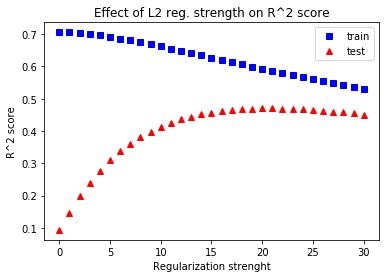

In [34]:
plt.plot(range(0, 31), scores_train, "bs", label = 'train')
plt.plot(range(0, 31), scores_test, "r^", label = 'test')
plt.xlabel("Regularization strenght")
plt.ylabel('R^2 score')
plt.legend()
plt.title("Effect of L2 reg. strength on R^2 score")
plt.show()